In [1]:
import numpy as np
import scipy
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt


In [90]:
class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        self.k=k
        self.dim = dim
        if(init_mu is None):
            init_mu = np.random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = np.random.rand(k, 3)
        self.colors = colors
        
    def init_em(self, X) : 
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))
        
    def e_step(self) :
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        self.p = self.z
        self.z /= self.z.sum(axis=1, keepdims=True)

    def m_step(self):
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        A = np.zeros((self.k-2, self.k))
        for i in range(self.k -2) :
            A[i][i], A[i][i+1], A[i][i+2] = 1, -2, 1
        A = np.matmul(A.T, A)
        B = np.linalg.inv(self.p.sum(axis=0)*np.eye(self.k) - A*10)
        self.mu = np.matmul(B, np.matmul(self.p.T, self.data))
        
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]

    def log_likelihood(self, X):
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)

    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)
            
    
    def assign(self, X):
        self.data = X
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        pred = np.argmax(self.z, axis = 1)
        return pred
        


        
        

In [3]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    label = []
    mean = np.random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = np.random.randn(dim, dim+10)
        cov = np.matmul(cov, cov.T) * 0.1
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True) 
    return x


In [4]:
cmap = plt.get_cmap("tab10")

def plot(title):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    fig = plt.figure(figsize=(4, 4))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-12, 12))
    ax.set_ylim((-12, 12))
    
    plt.title(title)
    #plt.savefig(title.replace(':', '_'))
    plt.show()
    plt.clf()


In [103]:
gmm = GMM(4, 2) 

[[-9.54445346 -9.45205862]
 [-4.98112446 -5.0289329 ]
 [-0.41779545 -0.60580719]
 [ 4.14553355  3.81731852]
 [ 8.70886255  8.24044423]]


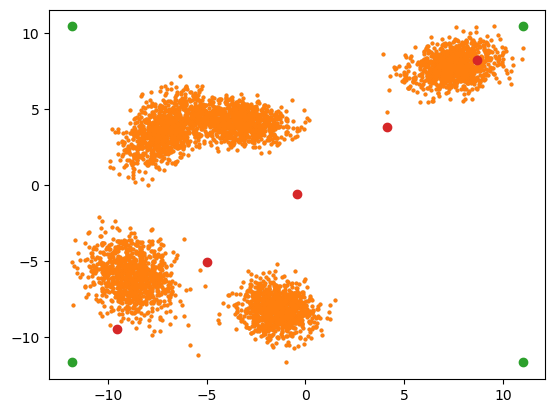

In [102]:
k = 5
dim = 2
samples = 1000
X= gen_data(k, dim, samples)
plt.scatter(X[:,0], X[:,1], s=4)
x1_min, x1_max = np.min(X[:,0]), np.max(X[:,0])
x2_min, x2_max = np.min(X[:,1]), np.max(X[:,1])
xxx = np.array([[x1_min, x2_max], [x1_max, x2_max], [x1_min, x2_min], [x1_max, x2_min]])
plt.scatter(xxx[:,0], xxx[:,1])
initpts= []
for i in range(k):
    x1_itv = (x1_max - x1_min)/k
    x2_itv = (x2_max - x2_min)/k
    initpts.append([x1_min+(0.5+i)*x1_itv, x2_min+(0.5+i)*x2_itv])
initpts = np.array(initpts)
print(initpts)
plt.scatter(initpts[:,0],initpts[:,1])

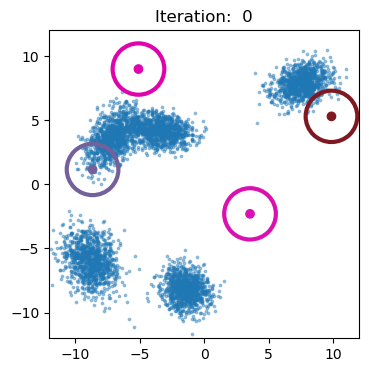

Iteration: 1, log-likelihood: -24343.3876


<Figure size 640x480 with 0 Axes>

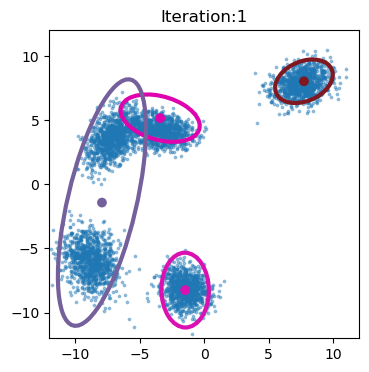

Iteration: 2, log-likelihood: -23824.2695
Iteration: 3, log-likelihood: -23693.4326
Iteration: 4, log-likelihood: -23633.7354
Iteration: 5, log-likelihood: -23588.5027
Iteration: 6, log-likelihood: -23547.3147
Iteration: 7, log-likelihood: -23507.3812
Iteration: 8, log-likelihood: -23467.6004
Iteration: 9, log-likelihood: -23427.4951
Iteration: 10, log-likelihood: -23386.8068
Iteration: 11, log-likelihood: -23345.2599


<Figure size 640x480 with 0 Axes>

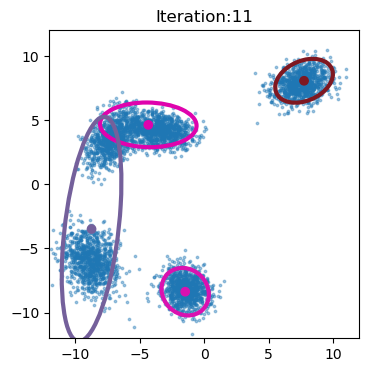

Iteration: 12, log-likelihood: -23302.3280
Iteration: 13, log-likelihood: -23256.8342
Iteration: 14, log-likelihood: -23206.1240
Iteration: 15, log-likelihood: -23144.3951
Iteration: 16, log-likelihood: -23059.7214
Iteration: 17, log-likelihood: -22931.7825
Iteration: 18, log-likelihood: -22767.2774
Iteration: 19, log-likelihood: -22703.3864
Iteration: 20, log-likelihood: -22708.0330
Iteration: 21, log-likelihood: -22708.4777


<Figure size 640x480 with 0 Axes>

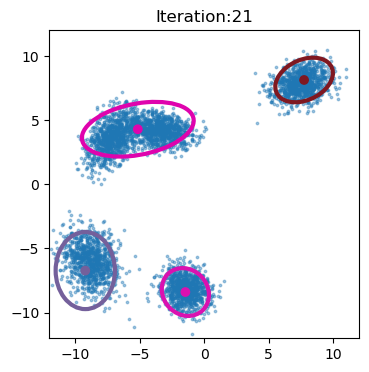

Iteration: 22, log-likelihood: -22708.4846
Iteration: 23, log-likelihood: -22708.4846
Iteration: 24, log-likelihood: -22708.4846
Iteration: 25, log-likelihood: -22708.4846
Iteration: 26, log-likelihood: -22708.4846
Iteration: 27, log-likelihood: -22708.4846
Iteration: 28, log-likelihood: -22708.4846
Iteration: 29, log-likelihood: -22708.4846
Iteration: 30, log-likelihood: -22708.4846
Iteration: 31, log-likelihood: -22708.4846


<Figure size 640x480 with 0 Axes>

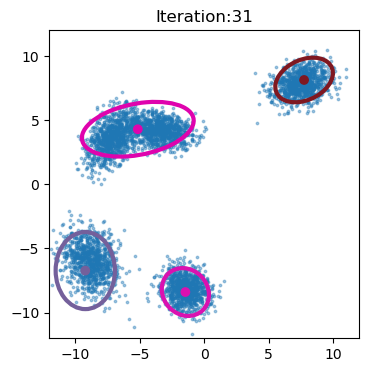

Iteration: 32, log-likelihood: -22708.4846
Iteration: 33, log-likelihood: -22708.4846
Iteration: 34, log-likelihood: -22708.4846
Iteration: 35, log-likelihood: -22708.4846
Iteration: 36, log-likelihood: -22708.4846
Iteration: 37, log-likelihood: -22708.4846
Iteration: 38, log-likelihood: -22708.4846
Iteration: 39, log-likelihood: -22708.4846
Iteration: 40, log-likelihood: -22708.4846
Iteration: 41, log-likelihood: -22708.4846


<Figure size 640x480 with 0 Axes>

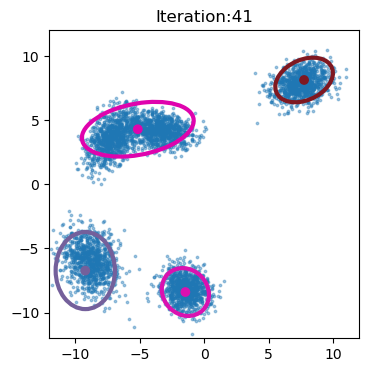

Iteration: 42, log-likelihood: -22708.4846
Iteration: 43, log-likelihood: -22708.4846
Iteration: 44, log-likelihood: -22708.4846
Iteration: 45, log-likelihood: -22708.4846
Iteration: 46, log-likelihood: -22708.4846
Iteration: 47, log-likelihood: -22708.4846
Iteration: 48, log-likelihood: -22708.4846
Iteration: 49, log-likelihood: -22708.4846
Iteration: 50, log-likelihood: -22708.4846


<Figure size 640x480 with 0 Axes>

In [104]:
# Training the GMM using EM

# Initialize EM algo with data
gmm.init_em(X)
num_iters = 50
# Saving log-likelihood
log_likelihood = [gmm.log_likelihood(X)]
# plotting
plot("Iteration:  0")
for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.log_likelihood(X))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
    
    if e%10 == 0 :
        plot(title="Iteration:" +  str(e+1))


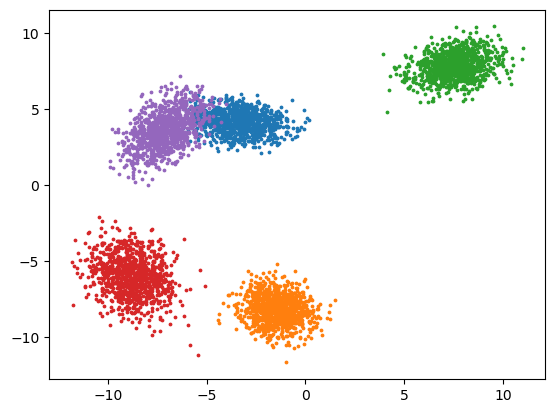

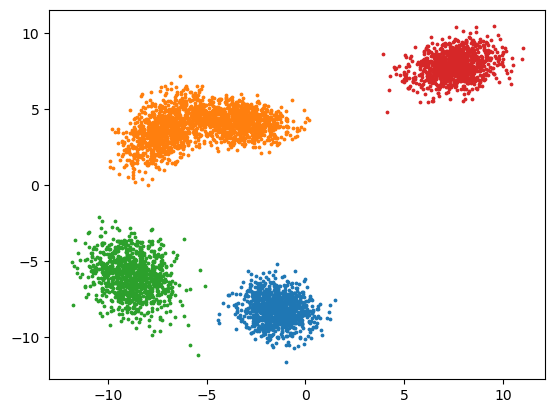

In [105]:
cmap = plt.get_cmap("tab10")
colors = ['red', 'orange', 'yellow', 'g', 'b', 'navy', 'purple']
plt.figure(1)
for i in range(10):
    plt.scatter(X[1000*(i):1000*(1+i), 0], X[1000*i:1000*(1+i), 1], color = cmap(i), s=3)
    
plt.figure(2)
Y = gmm.assign(X)
for x,y in zip(X,Y):
    plt.scatter(x[0], x[1], color = cmap(y), s=3)

